In [473]:
from sys import executable
!{executable} -m pip install numpy pandas seaborn matplotlib sklearn graphviz nltk scipy deeppavlov catboost

     |████████████████████████████████| 10.9 MB 1.3 MB/s eta 0:00:012     |█████▋                          | 1.9 MB 607 kB/s eta 0:00:15     |█████████████████▉              | 6.1 MB 3.6 MB/s eta 0:00:02


In [ ]:
!{executable} -m pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [2]:
# !{executable} -m deeppavlov install syntax_ru_syntagrus_bert

In [848]:
import numpy as np
import pandas as pd

import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import spatial
from statistics import mean
from scipy.cluster import hierarchy as sch

from deeppavlov import build_model, configs
from catboost import CatBoostClassifier, Pool

from nltk import word_tokenize, pos_tag
from nltk.translate import bleu_score
from nltk.translate.bleu_score import corpus_bleu

from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re
import string
import pickle
from glob import glob
from io import StringIO

In [228]:
import warnings
warnings.filterwarnings('ignore')

In [229]:
from nltk import download
download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mvshmakovmv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [230]:
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
pd.set_option('display.float_format', lambda x: f'{x :.2f}')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [231]:
base_dir = "./"

# Reading dataset

In [305]:
def get_df_from_csvs_in_path(d, sep=';'):
    all_files = glob(d + "/*.csv")
    df_list = [pd.read_csv(filename, index_col=None, header=0, sep=sep) for filename in all_files]

    return pd.concat(df_list, axis=0, ignore_index=True)

In [233]:
blogs_processed_dir = base_dir + 'data/blogs/processed/'

df = get_df_from_csvs_in_path(blogs_processed_dir)

df = df.dropna().reset_index()
df

index                                              EDU_1  \
0          0  После поездки в 2017 на Бали я вспомнил, что о...   
1          1  поэтому в 2018 полетели снова в теплые края, н...   
2          2              (только сейчас руки дошли написать!).   
3          3                         В общем, прекрасное место!   
4          4                               Остров не маленький,   
...      ...                                                ...   
11731  11752                  и примерно такой же будет всегда.   
11732  11753                Надеяться уже в принципе не на что.   
11733  11754  И не то чтобы у меня было для вас что-то получше,   
11734  11755               или что я могу сказать, где будущее.   
11735  11756     Все что я могу сказать что оно точно не здесь.   

                                                   EDU_2       Relation  
0      поэтому в 2018 полетели снова в теплые края, н...        cause_r  
1                                  есть, что посмотреть.  preparation_r  
2      поэтому в 2018 полетели снова в теплые края, н...   evaluation_r  
3      поэтому в 2018 полетели снова в теплые края, н...   evaluation_r  
4                                  есть, что посмотреть.        cause_r  
...                                                  ...            ...  
11731                                   она такая сейчас     sequence_m  
11732               Это неотъемлемые свойства платформы,        joint_m  
11733                Надеяться уже в принципе не на что.  elaboration_r  
11734  И не то чтобы у меня было для вас что-то получше,        joint_m  
11735  И не то чтобы у меня было для вас что-то получше,     contrast_m  

[11736 rows x 4 columns]

In [234]:
df.describe()

index
count 11736.00
mean   5881.30
std    3394.13
min       0.00
25%    2942.75
50%    5879.50
75%    8822.25
max   11756.00

# Feature extractors

In [235]:
features = ['num_of_words', 'avg_word_len', 'upcase_words_num', 'pos_tags', 'tf_idf']

In [825]:
test_edu = 'Современные технологии достигли такого уровня, что современная методология разработки создаёт предпосылки для позиций.'
test_edu_2 = 'Лишь базовые сценарии поведения пользователей, превозмогая сложившуюся непростую экономическую ситуацию.'

In [237]:
num_of_words = lambda edus: len(edus.split())
num_of_words(test_edu)

13

In [238]:
avg_word_len = lambda edus: mean([len(word) for word in edus.split()])
avg_word_len(test_edu)

8.153846153846153

In [239]:
upcase_words_num = lambda edu: len([word for word in edu.split() if word.istitle()])
upcase_words_num(test_edu)

1

In [240]:
num_unique_words = lambda edu: len(set(w for w in edu.split()))
num_unique_words(test_edu)

13

In [241]:
def pos_tags(edus):
    pos_tags = []

    for word in edus.split():
        word = word.lower()
        tokenized = word_tokenize(word)
        pos_tags.append(pos_tag(tokenized))

    return pos_tags

pos_tags(test_edu)

[[('современные', 'NN')],
 [('технологии', 'NN')],
 [('достигли', 'NN')],
 [('такого', 'NN')],
 [('уровня', 'NN'), (',', ',')],
 [('что', 'NN')],
 [('современная', 'NN')],
 [('методология', 'NN')],
 [('разработки', 'NN')],
 [('создаёт', 'NN')],
 [('предпосылки', 'NN')],
 [('для', 'NN')],
 [('позиций', 'NN'), ('.', '.')]]

In [925]:
def tf_idf(edus):
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=None, use_idf=True, min_df=1,
                                       smooth_idf=False, preprocessor=lambda edus: re.sub(r"[{}]".format(string.punctuation), " ", edus))

    return tfidf_vectorizer.fit_transform(edus.split())

# tf_idf(test_edu)

In [926]:
morph_correlation = lambda row, row_2: spatial.distance.correlation(row, row_2)
morph_canberra = lambda row, row_2: spatial.distance.canberra([row], [row_2])
morph_hamming = lambda row, row_2: spatial.distance.hamming(row, row_2)

# morph_correlation(tf_idf(test_edu), tf_idf(test_edu_2))

In [859]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics import pairwise_distances 
from sklearn.metrics.pairwise import euclidean_distances 

def ang_cos_tf_idf_sim(tfidf_matrix, tfidf_matrix_2):
    cos_dist = cosine_similarity(tfidf_matrix[0], tfidf_matrix)
#     cos_dist = euclidean_distances(tfidf_matrix, tfidf_matrix_2)
#     cos_dist = pairwise_distances(tfidf_matrix, tfidf_matrix_2, metric = 'manhattan')
#     cos_dist = cosine_similarity(tfidf_matrix, tfidf_matrix_2)

    return np.arccos(cos_dist) * 2. / np.pi

ang_cos_tf_idf_sim(tf_idf(test_edu), tf_idf(test_edu_2))

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [839]:
get_bleu_score = lambda row, row_2: bleu_score.sentence_bleu([row], row_2, weights=(0.5,))
get_bleu_score(test_edu, test_edu_2)

0.7808356939911968

# Features extraction

In [246]:
def apply_bleu(columns):
    return get_bleu_score(columns[0], columns[1])

def extract_features(target_df):
    target_df['num_of_words_1'] = target_df.EDU_1.apply(num_of_words)
    target_df['avg_word_len_1'] = target_df.EDU_1.apply(avg_word_len)
    target_df['upcase_words_num_1'] = target_df.EDU_1.apply(upcase_words_num)
    target_df['num_unique_words_1'] = target_df.EDU_1.apply(num_unique_words)
    target_df["count_words_title_1"] = target_df.EDU_1.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    target_df["mean_word_len_1"] = target_df.EDU_1.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    target_df['words_vs_unique_1'] = target_df['num_unique_words_1'] / target_df['num_of_words_1']

    target_df['num_of_words_2'] = target_df.EDU_2.apply(num_of_words)
    target_df['avg_word_len_2'] = target_df.EDU_2.apply(avg_word_len)
    target_df['upcase_words_num_2'] = target_df.EDU_2.apply(upcase_words_num)
    target_df['num_unique_words_2'] = target_df.EDU_2.apply(num_unique_words)
    target_df["count_words_title_2"] = target_df.EDU_2.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    target_df["mean_word_len_2"] = target_df.EDU_2.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    target_df['words_vs_unique_2'] = target_df['num_unique_words_2'] / target_df['num_of_words_2']

    target_df['bleu_score'] = list(map(apply_bleu, zip(target_df['EDU_1'], target_df['EDU_2'])))

    return target_df

extract_features(df)

index                                              EDU_1  \
0          0  После поездки в 2017 на Бали я вспомнил, что о...   
1          1  поэтому в 2018 полетели снова в теплые края, н...   
2          2              (только сейчас руки дошли написать!).   
3          3                         В общем, прекрасное место!   
4          4                               Остров не маленький,   
...      ...                                                ...   
11731  11752                  и примерно такой же будет всегда.   
11732  11753                Надеяться уже в принципе не на что.   
11733  11754  И не то чтобы у меня было для вас что-то получше,   
11734  11755               или что я могу сказать, где будущее.   
11735  11756     Все что я могу сказать что оно точно не здесь.   

                                                   EDU_2       Relation  \
0      поэтому в 2018 полетели снова в теплые края, н...        cause_r   
1                                  есть, что посмотреть.  preparation_r   
2      поэтому в 2018 полетели снова в теплые края, н...   evaluation_r   
3      поэтому в 2018 полетели снова в теплые края, н...   evaluation_r   
4                                  есть, что посмотреть.        cause_r   
...                                                  ...            ...   
11731                                   она такая сейчас     sequence_m   
11732               Это неотъемлемые свойства платформы,        joint_m   
11733                Надеяться уже в принципе не на что.  elaboration_r   
11734  И не то чтобы у меня было для вас что-то получше,        joint_m   
11735  И не то чтобы у меня было для вас что-то получше,     contrast_m   

       num_of_words_1  avg_word_len_1  upcase_words_num_1  num_unique_words_1  \
0                  19            4.42                   2                  18   
1                  12            4.67                   2                  11   
2                   5            6.60                   0                   5   
3                   4            5.75                   1                   4   
4                   3            6.00                   1                   3   
...               ...             ...                 ...                 ...   
11731               6            4.67                   0                   6   
11732               7            4.14                   1                   7   
11733              11            3.55                   1                  11   
11734               7            4.29                   0                   7   
11735              10            3.70                   1                   9   

       count_words_title_1  mean_word_len_1  words_vs_unique_1  \
0                        2             4.42               0.95   
1                        2             4.67               0.92   
2                        0             6.60               1.00   
3                        1             5.75               1.00   
4                        1             6.00               1.00   
...                    ...              ...                ...   
11731                    0             4.67               1.00   
11732                    1             4.14               1.00   
11733                    1             3.55               1.00   
11734                    0             4.29               1.00   
11735                    1             3.70               0.90   

       num_of_words_2  avg_word_len_2  upcase_words_num_2  num_unique_words_2  \
0                  12            4.67                   2                  11   
1                   3            6.33                   0                   3   
2                  12            4.67                   2                  11   
3                  12            4.67                   2                  11   
4                   3            6.33                   0                   3   
...               ...             ...            

In [247]:
deeppavlov_model = build_model("ru_syntagrus_joint_parsing", download=True)

2020-05-29 17:56:47.210 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'ru_syntagrus_joint_parsing' as '/usr/local/lib/python3.7/site-packages/deeppavlov/configs/syntax/ru_syntagrus_joint_parsing.json'
2020-05-29 17:56:50.600 INFO in 'deeppavlov.download'['download'] at line 117: Skipped http://files.deeppavlov.ai/deeppavlov_data/syntax_parser/syntax_ru_syntagrus_bert.tar.gz download because of matching hashes
2020-05-29 17:56:54.485 INFO in 'deeppavlov.download'['download'] at line 117: Skipped http://files.deeppavlov.ai/deeppavlov_data/morpho_tagger/BERT/morpho_ru_syntagrus_bert.tar.gz download because of matching hashes
2020-05-29 17:56:56.962 INFO in 'deeppavlov.download'['download'] at line 117: Skipped http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_v1.tar.gz download because of matching hashes
2020-05-29 17:56:57.646 INFO in 'deeppavlov.download'['download'] at line 117: Skipped http://files.deeppavlov.ai/deeppavlov_data/morph

INFO:tensorflow:Restoring parameters from /Users/mvshmakovmv/.deeppavlov/models/morpho_ru_syntagrus/model


2020-05-29 17:57:38.649 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 52: No load path is set for UDPymorphyLemmatizer!
2020-05-29 17:57:39.996 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /Users/mvshmakovmv/.deeppavlov/models/syntax_ru_syntagrus/deps.dict]
2020-05-29 17:58:03.622 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /Users/mvshmakovmv/.deeppavlov/models/syntax_ru_syntagrus/model_joint]


INFO:tensorflow:Restoring parameters from /Users/mvshmakovmv/.deeppavlov/models/syntax_ru_syntagrus/model_joint


In [271]:
from tqdm import tqdm
from datetime import datetime

columns_1 = ['nouns_count_1', 'verbs_count_1', 'adj_count_1', 'adv_count_1', 'aux_count_1', \
             'num_count_1', 'vbd_count_1', 'nouns_vs_words_1', 'adjectives_vs_words_1', 'verbs_vs_words_1',  \
             'adp_count_1', 'cconj_count_1', 'sconj_count_1', 'part_count_1', 'pron_count_1']
columns_2 = ['nouns_count_2', 'verbs_count_2', 'adj_count_2', 'adv_count_2', 'aux_count_2', \
             'num_count_2', 'vbd_count_2', 'nouns_vs_words_2', 'adjectives_vs_words_2', 'verbs_vs_words_2', \
             'adp_count_2', 'cconj_count_2', 'sconj_count_2', 'part_count_2', 'pron_count_2']

def extract_from_deeppavlov(target_df, boundaries, batch_number, batch_size=500):
    temp_df = pd.DataFrame(index=range(len(target_df)), columns=[*columns_1, *columns_2])

    for batch_index in tqdm(list(range(0, len(target_df), batch_size))):
        batch_1 = target_df.EDU_1[batch_index : batch_index+batch_size]
        batch_2 = target_df.EDU_2[batch_index : batch_index+batch_size]

        for idx, parsed_edu_tsv_1 in enumerate(deeppavlov_model(list(batch_1))):
            index = idx + batch_index
            parsed_edu_1 = pd.read_csv(StringIO(parsed_edu_tsv_1), sep='\t', header=None)

            temp_df['nouns_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'NOUN'])
            temp_df['verbs_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'VERB'])
            temp_df['adj_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'ADJ'])
            temp_df['adv_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'ADV'])
            temp_df['aux_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'AUX'])
            temp_df['num_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'NUM'])
            temp_df['vbd_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'VBD'])

            temp_df['adp_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'ADP'])
            temp_df['cconj_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'CCONJ'])
            temp_df['sconj_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'SCONJ'])
            temp_df['part_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'PART'])
            temp_df['pron_count_1'][index] = len([w for w in parsed_edu_1[3] if w == 'PRON'])

            temp_df['nouns_vs_words_1'][index] = temp_df['nouns_count_1'][index] / target_df['num_of_words_1'][index]
            temp_df['adjectives_vs_words_1'][index] = temp_df['adj_count_1'][index] / target_df['num_of_words_1'][index]
            temp_df['verbs_vs_words_1'][index] = temp_df['verbs_count_1'][index] / target_df['num_of_words_1'][index]

        for idx, parsed_edu_tsv_2 in enumerate(deeppavlov_model(list(batch_2))):
            index = idx + batch_index
            parsed_edu_2 = pd.read_csv(StringIO(parsed_edu_tsv_2), sep='\t', header=None)

            temp_df['nouns_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'NOUN'])
            temp_df['verbs_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'VERB'])
            temp_df['adj_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'ADJ'])
            temp_df['adv_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'ADV'])
            temp_df['aux_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'AUX'])
            temp_df['num_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'NUM'])
            temp_df['vbd_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'VBD'])

            temp_df['adp_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'ADP'])
            temp_df['cconj_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'CCONJ'])
            temp_df['sconj_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'SCONJ'])
            temp_df['part_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'PART'])
            temp_df['pron_count_2'][index] = len([w for w in parsed_edu_2[3] if w == 'PRON'])

            temp_df['nouns_vs_words_2'][index] = temp_df['nouns_count_2'][index] / target_df['num_of_words_2'][index]
            temp_df['adjectives_vs_words_2'][index] = temp_df['adj_count_2'][index] / target_df['num_of_words_2'][index]
            temp_df['verbs_vs_words_2'][index] = temp_df['verbs_count_2'][index] / target_df['num_of_words_2'][index]

    pd.merge(target_df, temp_df, left_index=True, right_index=True).to_csv(
        f'./deeppavlov_parsed/{"batch_" + str(batch_number) + "_" + str(boundaries)}.csv', index=None, sep='\t')
 
    return pd.merge(target_df, temp_df, left_index=True, right_index=True)

In [299]:
extract_from_deeppavlov(df[4000:4500].reset_index(), '4000_4500', 9)

100%|██████████| 1/1 [30:11<00:00, 1811.95s/it]


level_0  index                                              EDU_1  \
0       4000   4009  И, разумеется, вдоль было множество сторожевых...   
1       4001   4010  Заброшенная церковь в Тавкавта, куда мы не поп...   
2       4002   4011                                    Двигаясь назад,   
3       4003   4012                                   устроили пикник.   
4       4004   4013                Монастырь оправдывает свое название   
..       ...    ...                                                ...   
495     4495   4507                           я ни когда туда не ходил   
496     4496   4508                         и ни чего об этом не знал,   
497     4497   4509  но время от времени слушал страшные истории об...   
498     4498   4510                       и по-настоящему в это верил.   
499     4499   4511  Даже сцена из фильма Иван Васильевич меняет пр...   

                                                 EDU_2       Relation  \
0    В общем, это древняя дорога из одной части Гру...        joint_m   
1    Самое внятное описание этого места, найденное ...  elaboration_r   
2                нашли небольшую полянку у самой реки,    condition_r   
3                нашли небольшую полянку у самой реки,        joint_m   
4    — ущелье Кавтуры действительно каменистое. Гру...     evidence_r   
..                                                 ...            ...   
495                                То есть как боялся:  elaboration_r   
496                           я ни когда туда не ходил        joint_m   
497                           я ни когда туда не ходил     contrast_m   
498  но время от времени слушал страшные истории об...   evaluation_r   
499  где Шпак отбойным молотком длбит в рот пациент...  attribution_r   

     num_of_words_1  avg_word_len_1  upcase_words_num_1  num_unique_words_1  \
0                 7            7.14                   1                   7   
1                21            5.71                   8                  15   
2                 2            7.00                   1                   2   
3                 2            7.50                   0                   2   
4                 4            8.00                   1                   4   
..              ...             ...                 ...                 ...   
495               6            3.17                   0                   6   
496               7            2.86                   0                   7   
497              11            5.55                   0                  11   
498               5            4.80                   0                   5   
499               8            5.88                   3                   8   

     count_words_title_1  ...  num_count_2  vbd_count_2  nouns_vs_words_2  \
0                      1  ...            1            0              0.23   
1                      8  ...            0            0              0.38   
2                      1  ...            0            0              0.33   
3                      0  ...            0            0              0.33   
4                      1  ...            0            0              0.25   
..                   ...  ...          ...          ...               ...   
495                    0  ...            0            0              0.00   
496                    0  ...            0            0              0.00   
497                    0  ...            0            0              0.00   
498                    0  ...            0            0              0.36   
499                    3  ...            0            0              0.36   

     adjectives_vs_words_2  verbs_vs_words_2  adp_count_2  cconj_count_2  \
0                     0.23              0.00            4              0   
1                     0.25              0.12            1              0   
2                     0.33              0.17            1              0   
3                     0.33              0.17            1    

# Data preprocessing

In [772]:
def get_df_from_csvs_in_path_2(d, sep=';'):
    all_files = glob(d + "/*.csv")
    df_list = [pd.read_csv(filename, index_col='level_0', header=0, sep=sep) for filename in all_files]

    return pd.concat(df_list, axis=0, ignore_index=True)

In [872]:
df = get_df_from_csvs_in_path_2('./data/blogs/deeppavlov_parsed', '\t')

df = df.dropna().reset_index()
df

level_0  index                                              EDU_1  \
0            0      0  После поездки в 2017 на Бали я вспомнил, что о...   
1            1      1  поэтому в 2018 полетели снова в теплые края, н...   
2            2      2              (только сейчас руки дошли написать!).   
3            3      3                         В общем, прекрасное место!   
4            4      4                               Остров не маленький,   
...        ...    ...                                                ...   
11731    11731   2002                             Стойте! А как же name?   
11732    11732   2003  Не стоит забывать, что JavaScript мультипаради...   
11733    11733   2004  где есть элементы объектно-ориентированного по...   
11734    11734   2005  где функцию можно рассматривать как объект со ...   
11735    11735   2006         К таким свойствам относится свойство name,   

                                                   EDU_2       Relation  \
0      поэтому в 2018 полетели снова в теплые края, н...        cause_r   
1                                  есть, что посмотреть.  preparation_r   
2      поэтому в 2018 полетели снова в теплые края, н...   evaluation_r   
3      поэтому в 2018 полетели снова в теплые края, н...   evaluation_r   
4                                  есть, что посмотреть.        cause_r   
...                                                  ...            ...   
11731  Не стоит забывать, что JavaScript мультипаради...  preparation_r   
11732  И лично для себя открыл в спецификации то, как...   background_r   
11733  Не стоит забывать, что JavaScript мультипаради...  elaboration_r   
11734  где есть элементы объектно-ориентированного по...  elaboration_r   
11735  где функцию можно рассматривать как объект со ...  elaboration_r   

       num_of_words_1  avg_word_len_1  upcase_words_num_1  num_unique_words_1  \
0                  19            4.42                   2                  18   
1                  12            4.67                   2                  11   
2                   5            6.60                   0                   5   
3                   4            5.75                   1                   4   
4                   3            6.00                   1                   3   
...               ...             ...                 ...                 ...   
11731               5            3.60                   2                   5   
11732               8            8.75                   1                   8   
11733               5            9.60                   0                   5   
11734               9            6.22                   0                   9   
11735               6            6.17                   1                   6   

       count_words_title_1  ...  num_count_2  vbd_count_2  nouns_vs_words_2  \
0                        2  ...            1            0              0.17   
1                        2  ...            0            0              0.00   
2                        0  ...            1            0              0.17   
3                        1  ...            1            0              0.17   
4                        1  ...            0            0              0.00   
...                    ...  ...          ...          ...               ...   
11731                    2  ...            0            0              0.25   
11732                    1  ...            0            0              0.23   
11733                    0  ...            0            0              0.25   
11734                    0  ...            0            0              0.40   
11735                    1  ...            0            0              0.33   

       adjectives_vs_words_2  verbs_vs_words_2  adp_count_2  cconj_count_2  \
0                       0.08              0.08            4              0   
1                       0.00              0.67            0              0   
2                       0.08         

In [873]:
rels_to_classify = []

def preprocess(target_df):
    global rels_to_classify

    # We need to bound the amount of available classes and memoize it
    if (len(rels_to_classify) == 0):
        counts = target_df.Relation.value_counts().loc[lambda x: x > 500]
        rels_to_classify = list(target_df.Relation[counts.index].index)
    target_df = target_df[target_df.Relation.isin(rels_to_classify)]

    # Encoding categorical Relation varible
    relations_mapping = {'joint_m': 0,
                     'elaboration_r': 1,
                     'contrast_m': 2,
                     'cause_r': 3,
                     'evaluation_r': 4,
                     'condition_r': 5,
                     'sequence_m': 6,
                     'preparation_r': 7}

    target_df.Relation = target_df.Relation.apply(lambda x: relations_mapping[x])

    # Drop categorical varibles
    categorical = target_df.select_dtypes(include=['object']).columns
    target_df.drop(columns=categorical, inplace=True)

    # MinMaxScaler scaling
    cols_without_relation = target_df.columns[target_df.columns != 'Relation']
    target_df[cols_without_relation] = StandardScaler().fit_transform(target_df[cols_without_relation])

    target_df.dropna(inplace=True)

    return target_df

In [874]:
df = preprocess(df)
rels_to_classify

['joint_m',
 'elaboration_r',
 'contrast_m',
 'cause_r',
 'evaluation_r',
 'condition_r',
 'sequence_m',
 'preparation_r']

In [875]:
df

level_0  index  Relation  num_of_words_1  avg_word_len_1  \
0        -1.71  -1.74         3            2.57           -0.87   
1        -1.71  -1.74         7            1.10           -0.71   
2        -1.71  -1.74         4           -0.37            0.54   
3        -1.71  -1.74         4           -0.58           -0.01   
4        -1.71  -1.74         3           -0.79            0.15   
...        ...    ...       ...             ...             ...   
11730     1.73  -1.15         3            2.15            0.04   
11731     1.73  -1.15         7           -0.37           -1.40   
11733     1.73  -1.15         1           -0.37            2.48   
11734     1.73  -1.15         1            0.47            0.30   
11735     1.73  -1.15         1           -0.16            0.26   

       upcase_words_num_1  num_unique_words_1  count_words_title_1  \
0                    0.69                2.67                 0.69   
1                    0.69                1.02                 0.69   
2                   -0.38               -0.39                -0.38   
3                    0.15               -0.62                 0.15   
4                    0.15               -0.86                 0.15   
...                   ...                 ...                  ...   
11730               -0.38                2.20                -0.38   
11731                0.69               -0.39                 0.69   
11733               -0.38               -0.39                -0.38   
11734               -0.38                0.55                -0.38   
11735                0.15               -0.15                 0.15   

       mean_word_len_1  words_vs_unique_1  ...  num_count_2  vbd_count_2  \
0                -0.87              -1.24  ...         2.13         0.00   
1                -0.71              -2.09  ...        -0.32         0.00   
2                 0.54               0.21  ...         2.13         0.00   
3                -0.01               0.21  ...         2.13         0.00   
4                 0.15               0.21  ...        -0.32         0.00   
...                ...                ...  ...          ...          ...   
11730             0.04              -1.41  ...        -0.32         0.00   
11731            -1.40               0.21  ...        -0.32         0.00   
11733             2.48               0.21  ...        -0.32         0.00   
11734             0.30               0.21  ...        -0.32         0.00   
11735             0.26               0.21  ...        -0.32         0.00   

       nouns_vs_words_2  adjectives_vs_words_2  verbs_vs_words_2  adp_count_2  \
0                 -0.49                  -0.06             -0.63         3.34   
1                 -1.47                  -0.71              2.94        -0.84   
2                 -0.49                  -0.06             -0.63         3.34   
3                 -0.49                  -0.06             -0.63         3.34   
4                 -1.47                  -0.71              2.94        -0.84   
...                 ...                    ...               ...          ...   
11730             -0.63                  -0.71             -0.27        -0.84   
11731             -0.00                   0.27              0.39        -0.84   
11733             -0.00                   0.27              0.39        -0.84   
11734              0.88                   0.86              0.08        -0.84   
11735              0.49                  -0.71             -0.46         0.21   

       cconj_count_2  sconj_count_2  part_count_2  pron_count_2  
0              -0.50          -0.41         -0.54         -0.75  
1              -0.50          -0.41         -0.54          0.56  
2              -0.50          -0.41         -0.54         -0.75  
3              -0.50          -0.41         -0.54         -0.75  
4              -0.50          -0.41         -0.54          0.56  
...              ...            ...           ...           ...  
11730        

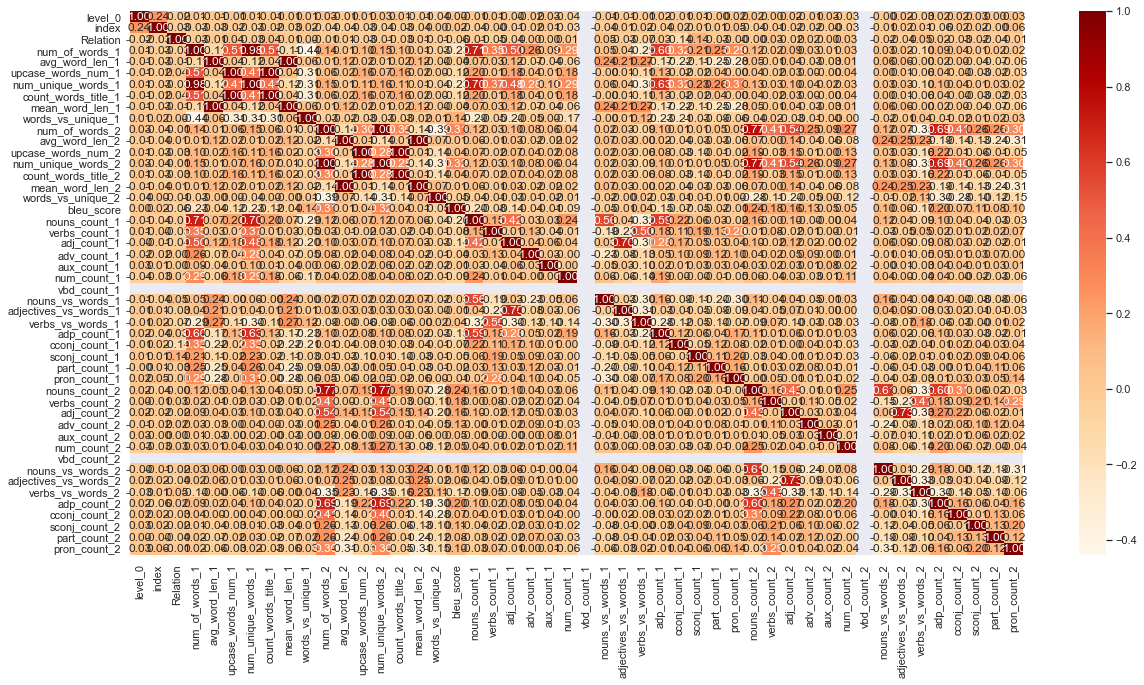

In [876]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='OrRd')

In [877]:
df.drop(columns=['index', 'level_0', \
                 'num_unique_words_1', 'upcase_words_num_1', 'avg_word_len_1', 'nouns_count_1', 'adj_count_1', 'vbd_count_1', \
                 'num_unique_words_2', 'upcase_words_num_2', 'avg_word_len_2', 'nouns_count_2', 'adj_count_2', 'vbd_count_2'], inplace=True)

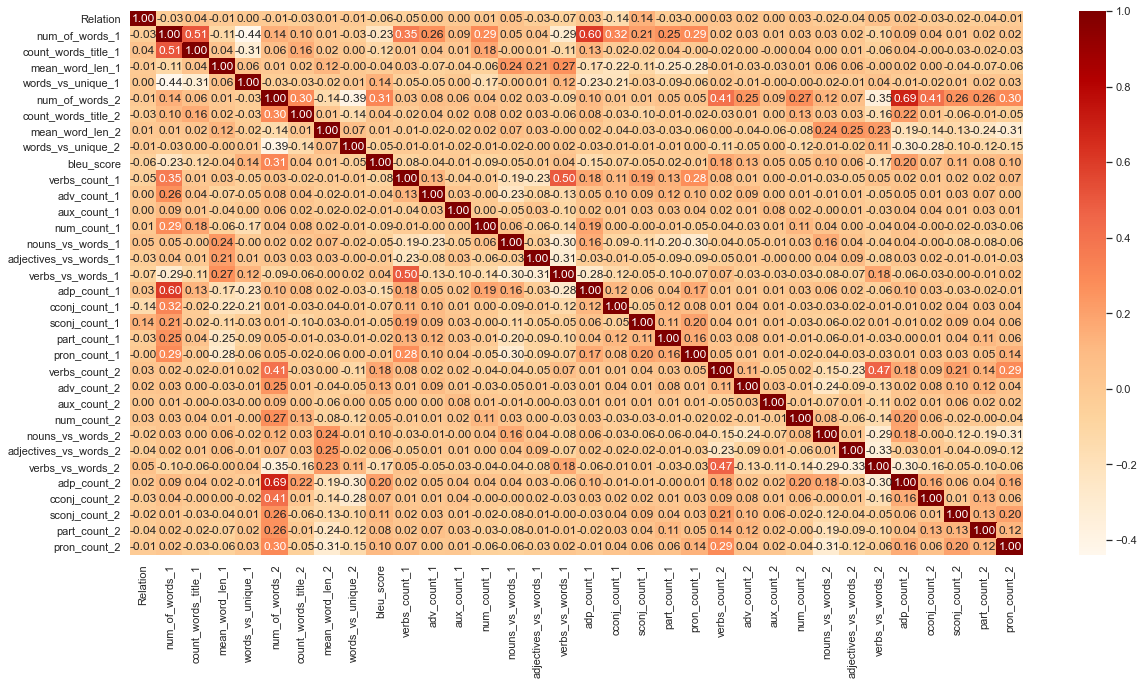

In [878]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='OrRd')

In [879]:
X = df.drop(columns=['Relation'])
y = df.Relation

In [880]:
X

num_of_words_1  count_words_title_1  mean_word_len_1  \
0                2.57                 0.69            -0.87   
1                1.10                 0.69            -0.71   
2               -0.37                -0.38             0.54   
3               -0.58                 0.15            -0.01   
4               -0.79                 0.15             0.15   
...               ...                  ...              ...   
11730            2.15                -0.38             0.04   
11731           -0.37                 0.69            -1.40   
11733           -0.37                -0.38             2.48   
11734            0.47                -0.38             0.30   
11735           -0.16                 0.15             0.26   

       words_vs_unique_1  num_of_words_2  count_words_title_2  \
0                  -1.24            1.12                 1.29   
1                  -2.09           -0.96                -1.00   
2                   0.21            1.12                 1.29   
3                   0.21            1.12                 1.29   
4                   0.21           -0.96                -1.00   
...                  ...             ...                  ...   
11730              -1.41           -0.04                 0.14   
11731               0.21            0.20                 0.14   
11733               0.21            0.20                 0.14   
11734               0.21           -0.50                -1.00   
11735               0.21            0.43                -1.00   

       mean_word_len_2  words_vs_unique_2  bleu_score  verbs_count_1  ...  \
0                -0.78              -3.04        0.05           1.31  ...   
1                 0.32               0.23       -2.00          -0.01  ...   
2                -0.78              -3.04        0.50           1.31  ...   
3                -0.78              -3.04        0.15          -1.33  ...   
4                 0.32               0.23        0.92          -1.33  ...   
...                ...                ...         ...            ...  ...   
11730            -1.12               0.23       -1.99           2.63  ...   
11731             1.91               0.23       -0.61          -0.01  ...   
11733             1.91               0.23        0.64          -0.01  ...   
11734             2.47               0.23        0.49          -0.01  ...   
11735             0.25               0.23        0.89          -0.01  ...   

       aux_count_2  num_count_2  nouns_vs_words_2  adjectives_vs_words_2  \
0            -0.24         2.13             -0.49                  -0.06   
1            -0.24        -0.32             -1.47                  -0.71   
2            -0.24         2.13             -0.49                  -0.06   
3            -0.24         2.13             -0.49                  -0.06   
4            -0.24        -0.32             -1.47                  -0.71   
...            ...          ...               ...                    ...   
11730         4.16        -0.32             -0.63                  -0.71   
11731        -0.24        -0.32             -0.00                   0.27   
11733        -0.24        -0.32             -0.00                   0.27   
11734        -0.24        -0.32              0.88                   0.86   
11735        -0.24        -0.32              0.49                  -0.71   

       verbs_vs_words_2  adp_count_2  cconj_count_2  sconj_count_2  \
0                 -0.63         3.34          -0.50          -0.41   
1                  2.94        -0.84          -0.50          -0.41   
2                 -0.63         3.34          -0.50          -0.41   
3                 -0.63         3.34          -0.50          -0.41   
4                  2.94        -0.84          -0.50          -0.41   
...                 ...          ...            ...            ...   
11730             -0.27        -0.84          -0.50          -0.41   
11731              0.39        -0.84          -0.50           2.10   
1

In [881]:
y

0        3
1        7
2        4
3        4
4        3
        ..
11730    3
11731    7
11733    1
11734    1
11735    1
Name: Relation, Length: 9898, dtype: int64

# Classification

In [906]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

def train_and_verify(model, **kwargs):
    scores = []
    feature_weights = []

    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train, **kwargs)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))

        if hasattr(model, 'feature_importances_'):
            feature_weights.append(pd.Series(model.feature_importances_, index=X_train.columns))

    print(f'Mean from scores: {np.mean(scores):.2f}')
    print(f'Std from scores: {np.std(scores):.2f}')

    print(classification_report(y_test, y_pred))

    return scores, feature_weights

# Decision Tree Classifier 

In [908]:
dt_cls = DecisionTreeClassifier(max_depth=7)
scores, feature_weights = train_and_verify(dt_cls)

print(scores)
print(feature_weights[np.array(scores).argmax()])

Mean from scores: 0.37
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.44      0.60      0.51       495
           1       0.34      0.55      0.42       462
           2       0.32      0.18      0.23       234
           3       0.23      0.17      0.19       189
           4       0.24      0.09      0.13       194
           5       0.38      0.45      0.41       155
           6       0.41      0.05      0.09       132
           7       0.67      0.05      0.09       118

    accuracy                           0.36      1979
   macro avg       0.38      0.27      0.26      1979
weighted avg       0.37      0.36      0.33      1979

[0.3601010101010101, 0.37373737373737376, 0.3803030303030303, 0.36685194542698335, 0.36483072258716526]
num_of_words_1          0.08
count_words_title_1     0.12
mean_word_len_1         0.02
words_vs_unique_1       0.00
num_of_words_2          0.02
count_words_title_2     0.09
mean_word_len_2         0.

In [888]:
predicted = dt_cls.predict(X)
cm = confusion_matrix(y, predicted)

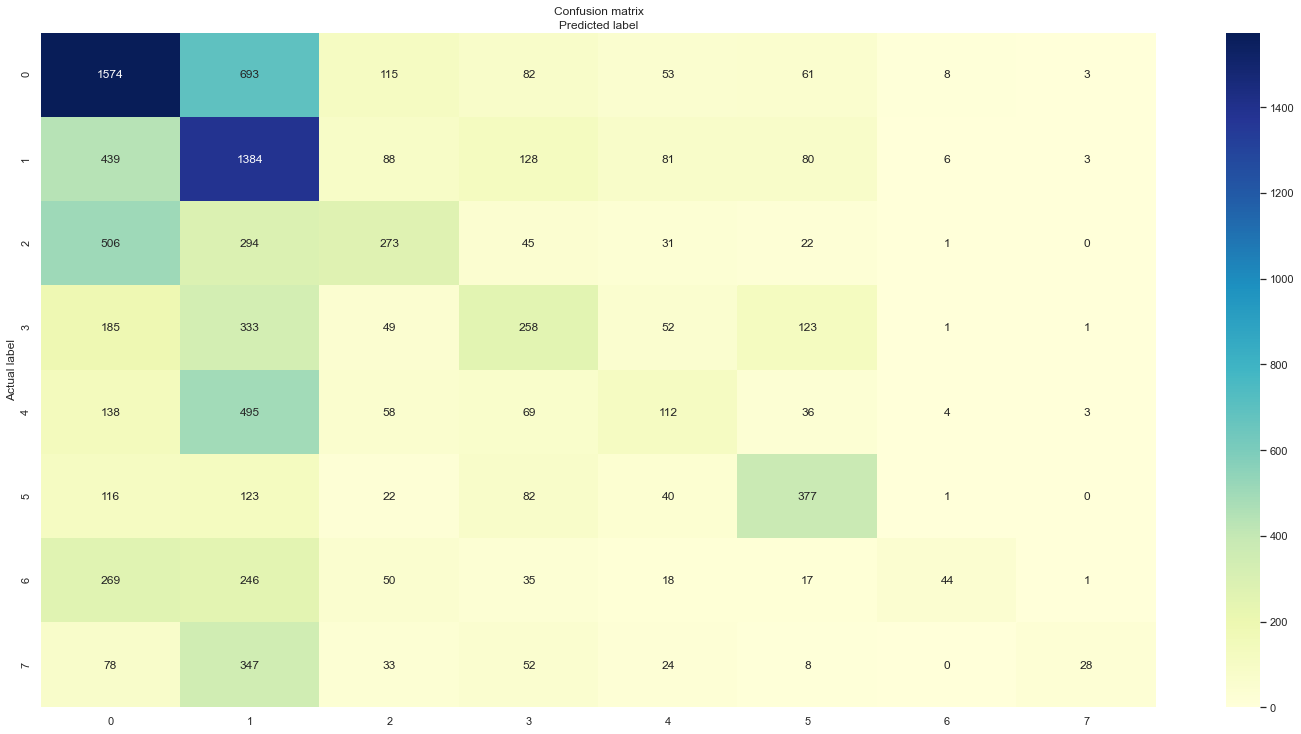

In [889]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [890]:
pickle.dump(dt_cls, open('classifiers/dt_cls.pkl', 'wb'))

# SVM

In [909]:
svm_cls = SVC(kernel='linear')
train_and_verify(svm_cls)

Mean from scores: 0.37
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.38      0.72      0.50       495
           1       0.37      0.63      0.47       462
           2       0.43      0.01      0.02       234
           3       0.31      0.08      0.13       189
           4       0.00      0.00      0.00       194
           5       0.42      0.52      0.47       155
           6       0.50      0.01      0.01       132
           7       0.00      0.00      0.00       118

    accuracy                           0.38      1979
   macro avg       0.30      0.25      0.20      1979
weighted avg       0.33      0.38      0.29      1979



([0.3601010101010101,
  0.3691919191919192,
  0.37727272727272726,
  0.36937847397675594,
  0.37897928246589185],
 [])

In [910]:
predicted = svm_cls.predict(X)
cm = confusion_matrix(y, predicted)

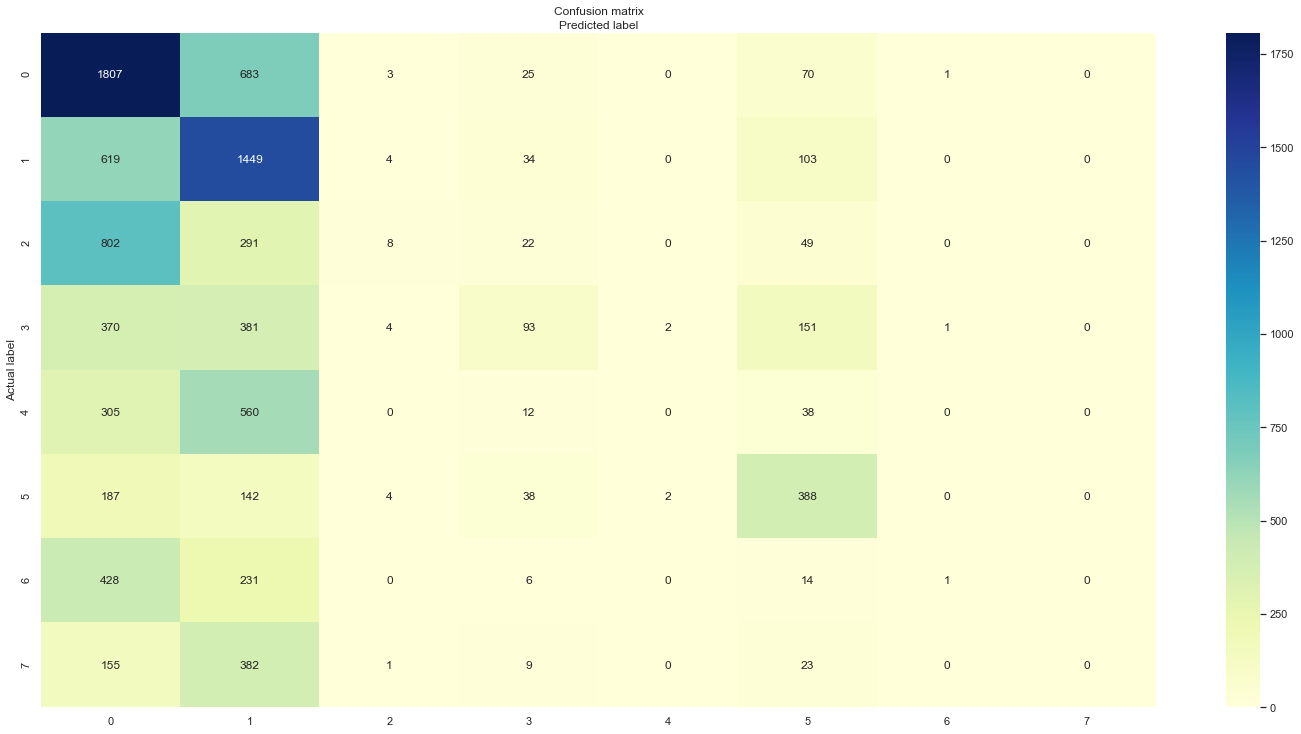

In [911]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [912]:
pickle.dump(svm_cls, open('classifiers/svm_cls.pkl', 'wb'))

# Gaussian Naive Bayes

In [913]:
gnb_cls = GaussianNB()
train_and_verify(gnb_cls)

Mean from scores: 0.27
Std from scores: 0.00
              precision    recall  f1-score   support

           0       0.41      0.35      0.38       495
           1       0.40      0.15      0.21       462
           2       0.30      0.33      0.31       234
           3       0.19      0.11      0.14       189
           4       0.21      0.25      0.23       194
           5       0.30      0.53      0.38       155
           6       0.13      0.45      0.21       132
           7       0.22      0.14      0.17       118

    accuracy                           0.28      1979
   macro avg       0.27      0.29      0.25      1979
weighted avg       0.32      0.28      0.27      1979



([0.26717171717171717,
  0.2727272727272727,
  0.2641414141414141,
  0.2738756947953512,
  0.2753916119252148],
 [])

In [914]:
predicted = gnb_cls.predict(X)
cm = confusion_matrix(y, predicted)

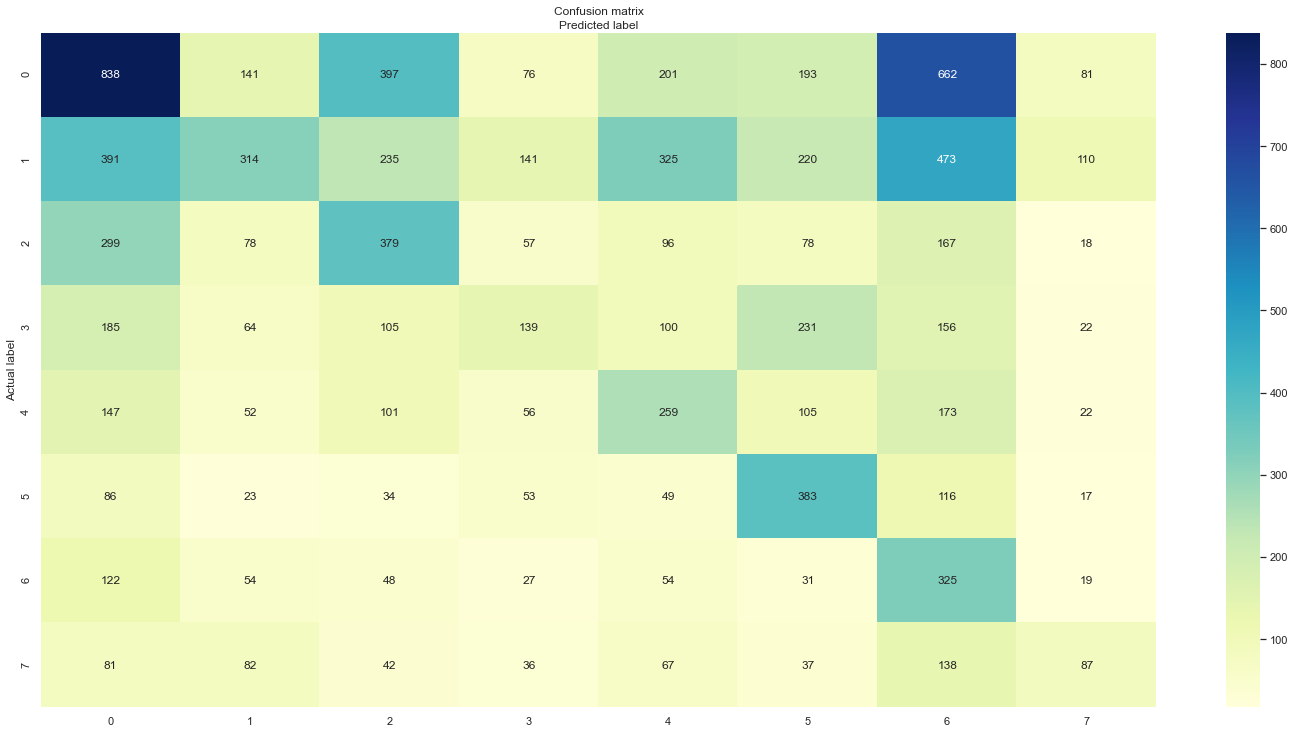

In [915]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [916]:
pickle.dump(gnb_cls, open('classifiers/gnb_cls.pkl', 'wb'))

# Random Forest Classifier

In [917]:
randf_cls = RandomForestClassifier(random_state=2020)
scores, feature_weights = train_and_verify(randf_cls)

print(scores)
print(feature_weights[np.array(scores).argmax()])

Mean from scores: 0.48
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.50      0.72      0.59       495
           1       0.42      0.63      0.50       462
           2       0.50      0.31      0.38       234
           3       0.46      0.29      0.36       189
           4       0.47      0.17      0.25       194
           5       0.51      0.53      0.52       155
           6       0.71      0.20      0.32       132
           7       0.53      0.14      0.23       118

    accuracy                           0.47      1979
   macro avg       0.51      0.37      0.39      1979
weighted avg       0.49      0.47      0.44      1979

[0.4782828282828283, 0.47525252525252526, 0.5, 0.48004042445679634, 0.4724608388074785]
num_of_words_1          0.05
count_words_title_1     0.03
mean_word_len_1         0.07
words_vs_unique_1       0.01
num_of_words_2          0.05
count_words_title_2     0.03
mean_word_len_2         0.07
words_vs_uniq

In [918]:
predicted = randf_cls.predict(X)
cm = confusion_matrix(y, predicted)

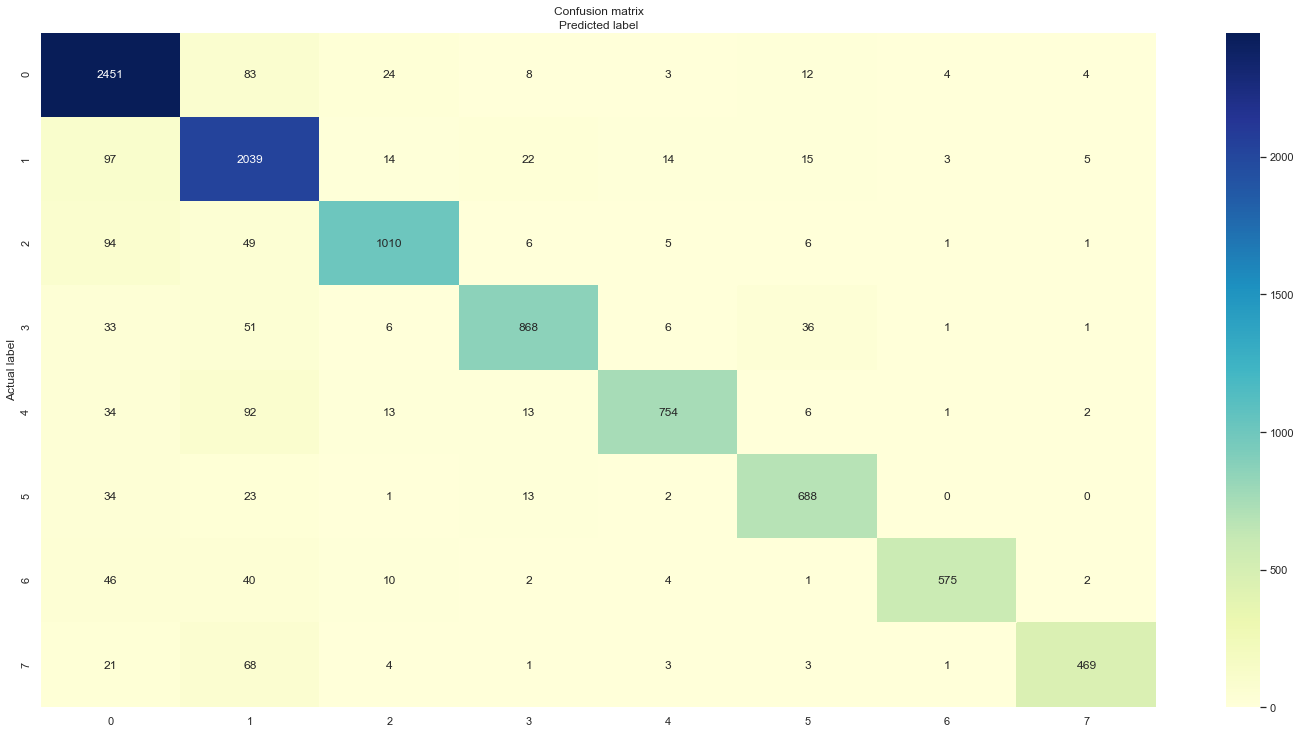

In [919]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [920]:
pickle.dump(randf_cls, open('classifiers/randf_cls.pkl', 'wb'))

# Catboost

In [921]:
catboost_cls = CatBoostClassifier()
scores, feature_weights = train_and_verify(catboost_cls, verbose=False, plot=True)

print(scores)
print(feature_weights[np.array(scores).argmax()])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mean from scores: 0.45
Std from scores: 0.01
              precision    recall  f1-score   support

           0       0.49      0.65      0.56       495
           1       0.42      0.56      0.48       462
           2       0.34      0.26      0.30       234
           3       0.40      0.28      0.33       189
           4       0.40      0.21      0.28       194
           5       0.45      0.54      0.49       155
           6       0.49      0.27      0.34       132
           7       0.47      0.16      0.24       118

    accuracy                           0.44      1979
   macro avg       0.44      0.37      0.38      1979
weighted avg       0.44      0.44      0.42      1979

[0.44343434343434346, 0.4621212121212121, 0.4676767676767677, 0.43456291056088936, 0.4421424962102072]
num_of_words_1          3.82
count_words_title_1     5.28
mean_word_len_1         7.07
words_vs_unique_1       0.32
num_of_words_2          2.70
count_words_title_2     3.98
mean_word_len_2         7.1

In [922]:
predicted = catboost_cls.predict(X)
cm = confusion_matrix(y, predicted)

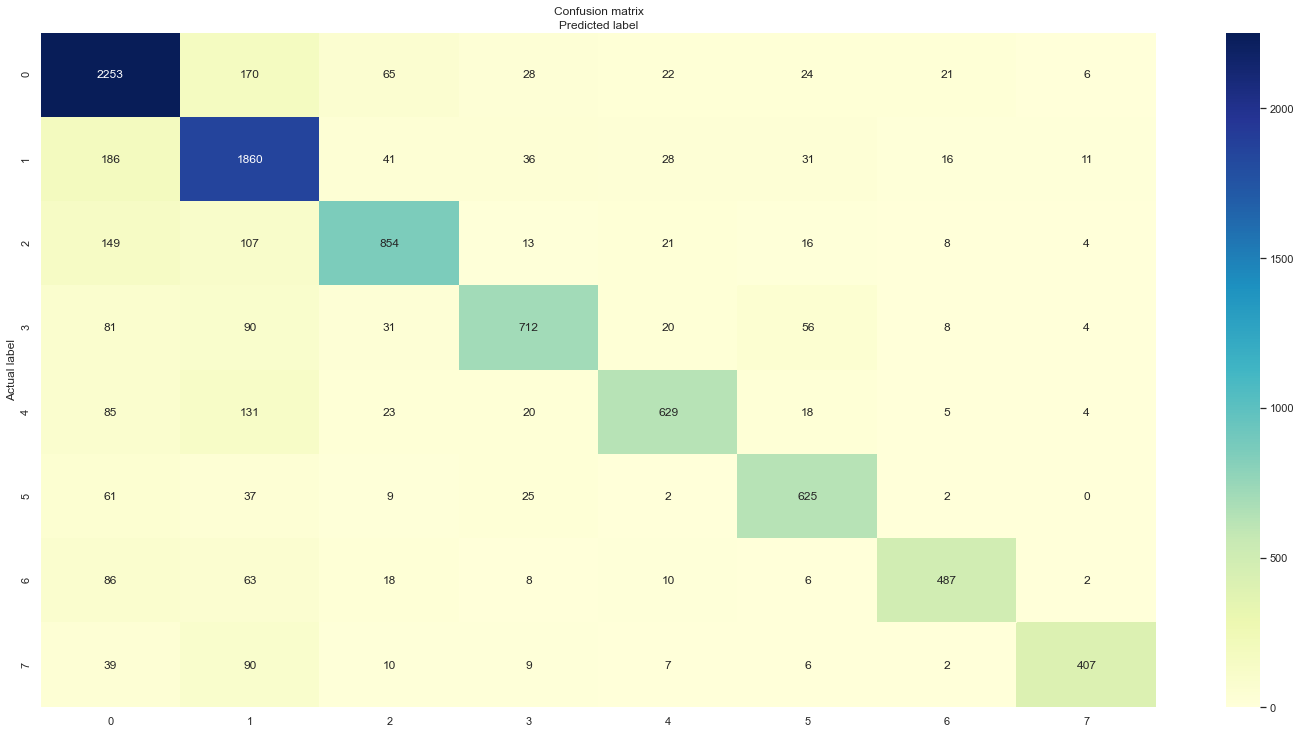

In [923]:
names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [924]:
pickle.dump(catboost_cls, open('classifiers/catboost_cls.pkl', 'wb'))

# Classification on schizo dataset

In [804]:
schizo_processed_dir = base_dir + 'data/schizo/schizo/processed/'
schizo_healthy_processed_dir = base_dir + 'data/schizo/healthy/processed/'

df_healthy = get_df_from_csvs_in_path(schizo_processed_dir)
df_schizo = get_df_from_csvs_in_path(schizo_healthy_processed_dir)

df_healthy.dropna(inplace=True)
df_schizo.dropna(inplace=True)

In [805]:
df_healthy
data = pd.get_dummies(df_healthy, prefix=['Relation'], columns=['Relation'], drop_first=True)
data

EDU_1  \
0    где-нибудь в предгорьях на Кавказе   
1                   либо в средней азии   
2                который груши собирает   
3                         взял лестницу   
4             по лестнице на дерево там   
..                                  ...   
309                     ты что-то забыл   
310                                типа   
311                    и потом дают ему   
312                        что он забыл   
313   и потом всё идёт по своим дорогам   

                                         EDU_2  Relation_background_r  \
0    действие происходит где-нибудь на юге там                      0   
1    действие происходит где-нибудь на юге там                      0   
2                  мужчина лет сорока пяти там                      0   
3                  мужчина лет сорока пяти там                      0   
4                  мужчина лет сорока пяти там                      0   
..                                         ...                    ...   
309                    и потом они ему свистят                      0   
310                    и потом они ему свистят                      0   
311                             груши собирает                      0   
312                           и потом дают ему                      0   
313                           и потом дают ему                      0   

     Relation_cause_r  Relation_circumstance_r  Relation_contrast_m  \
0                   0                        0                    0   
1                   0                        0                    1   
2                   0                        0                    0   
3                   0                        0                    0   
4                   0                        0                    0   
..                ...                      ...                  ...   
309                 0                        0                    0   
310                 0                        0                    0   
311                 0                        0                    0   
312                 0                        0                    1   
313                 0                        0                    0   

     Relation_elaboration_r  Relation_evaluation_r  Relation_evidence_r  \
0                         1                      0                    0   
1                         0                      0                    0   
2                         1                      0                    0   
3                         0                      0                    0   
4                         1                      0                    0   
..                      ...                    ...                  ...   
309                       0                      0                    0   
310                       0                      1                    0   
311                       0                      0                    0   
312                       0                      0                    0   
313                       0                      0                    0   

     Relation_joint_m  Relation_preparation_r  Relation_purpose_r  \
0                   0                       0                   0   
1                   0                       0                   0   
2                   0                       0                   0   
3                   1                       0                   0   
4                   0                       0                   0   
..                ...                     ...                 ...   
309                 0                       0                   0   
310                 0                       0                   0   
311                 0                       0                   0   
312                 0                       0                   0   
313                 0                       0                   0   

     Relation_restatement_r  Relation_result_r  Relation_

In [806]:
df_schizo

EDU_1  \
0                                   ну я б сказала   
1                  не очень правдоподобная история   
2                          потому что этот человек   
3                       убирающий собирающий груши   
4         наверняка он все-таки звук слышит хорошо   
..                                             ...   
544               он их за это угостил грушами вот   
545       это то есть мальчик такой ну благодарный   
546                              будем говорить да   
547  вот ну и в общем повёз это всё домой помощник   
548                          ну вот так вот у меня   

                                           EDU_2        Relation  
0                не очень правдоподобная история    evaluation_r  
1                         человек собирает груши   preparation_r  
2                не очень правдоподобная история         cause_r  
3                        потому что этот человек   elaboration_r  
4                        потому что этот человек         joint_m  
..                                           ...             ...  
544  но это самое а шляпа-то у него улетела тоже  circumstance_r  
545                            вот поехал дальше    antithesis_r  
546     это то есть мальчик такой ну благодарный    evaluation_r  
547                            вот поехал дальше      sequence_m  
548                                   он собирал    evaluation_r  

[549 rows x 3 columns]

In [807]:
# df_healthy = extract_features(df_healthy)
# extract_from_deeppavlov(df_healthy.reset_index(), 'heathy', 1)

In [808]:
df_healthy = pd.read_csv('./data/schizo/healthy/deeppavlov_features_heathy.csv', header=0, sep='\t')
df_healthy = preprocess(df_healthy)
df_healthy

index  Relation  num_of_words_1  avg_word_len_1  upcase_words_num_1  \
0    -1.73         1            0.52            0.79               11.14   
1    -1.72         2           -0.02           -0.65               -0.09   
2    -1.70         1           -0.57            1.27               -0.09   
3    -1.69         0           -1.11            0.79               -0.09   
4    -1.68         1            0.52           -0.51               -0.09   
..     ...       ...             ...             ...                 ...   
309   1.63         6           -0.57           -0.41               -0.09   
310   1.64         4           -1.66           -0.65               -0.09   
311   1.65         6           -0.02           -1.20               -0.09   
312   1.66         2           -0.57           -1.13               -0.09   
313   1.67         6            1.62           -0.76               -0.09   

     num_unique_words_1  count_words_title_1  mean_word_len_1  \
0                  0.56                11.14             0.79   
1                 -0.00                -0.09            -0.65   
2                 -0.56                -0.09             1.27   
3                 -1.12                -0.09             0.79   
4                  0.56                -0.09            -0.51   
..                  ...                  ...              ...   
309               -0.56                -0.09            -0.41   
310               -1.68                -0.09            -0.65   
311               -0.00                -0.09            -1.20   
312               -0.56                -0.09            -1.13   
313                1.67                -0.09            -0.76   

     words_vs_unique_1  num_of_words_2  ...  num_count_2  vbd_count_2  \
0                 0.15            0.56  ...        -0.38         0.00   
1                 0.15            0.56  ...        -0.38         0.00   
2                 0.15            0.14  ...         2.09         0.00   
3                 0.15            0.14  ...         2.09         0.00   
4                 0.15            0.14  ...         2.09         0.00   
..                 ...             ...  ...          ...          ...   
309               0.15            0.14  ...        -0.38         0.00   
310               0.15            0.14  ...        -0.38         0.00   
311               0.15           -1.12  ...        -0.38         0.00   
312               0.15           -0.28  ...        -0.38         0.00   
313               0.15           -0.28  ...        -0.38         0.00   

     nouns_vs_words_2  adjectives_vs_words_2  verbs_vs_words_2  adp_count_2  \
0                0.18                  -0.29             -0.28         0.62   
1                0.18                  -0.29             -0.28         0.62   
2                0.51                  -0.29             -1.18        -0.78   
3                0.51                  -0.29             -1.18        -0.78   
4                0.51                  -0.29             -1.18        -0.78   
..                ...                    ...               ...          ...   
309             -1.45                  -0.29             -0.10        -0.78   
310             -1.45                  -0.29             -0.10        -0.78   
311              1.00                  -0.29              1.51        -0.78   
312             -1.45                  -0.29              0.17        -0.78   
313             -1.45                  -0.29              0.17        -0.78   

     cconj_count_2  sconj_count_2  part_count_2  pron_count_2  
0            -0.47          -0.28         -0.31         -0.70  
1            -0.47          -0.28         -0.31         -0.70  
2            -0.47          -0.28         -0.31         -0.70  
3            -0.47          -0.28         -0.31         -0.70  
4            -0.47          -0.28         -0.31         -0.70  
..             ...            ...           ...           ...  
309           2.11          -0.28    

In [809]:
df_healthy.drop(columns=['index', 'num_unique_words_1', 'upcase_words_num_1', 'avg_word_len_1', \
                         'nouns_count_1', 'adj_count_1', 'vbd_count_1', 'num_unique_words_2', 'upcase_words_num_2', \
                         'avg_word_len_2', 'nouns_count_2', 'adj_count_2', 'vbd_count_2'], inplace=True)

In [810]:
# df_schizo = extract_features(df_schizo)
# extract_from_deeppavlov(df_schizo.reset_index(), 'schizo', 1)

In [811]:
df_schizo = pd.read_csv('./data/schizo/schizo/deeppavlov_features_schizo.csv', header=0, sep='\t')
df_schizo = preprocess(df_schizo)
df_schizo

index  Relation  num_of_words_1  avg_word_len_1  upcase_words_num_1  \
0    -1.66         4           -0.21           -1.57               -0.07   
1    -1.66         7           -0.21            1.35               -0.07   
2    -1.65         3           -0.21           -0.03               -0.07   
3    -1.64         1           -0.63            2.03               -0.07   
4    -1.64         0            0.61            0.55               -0.07   
..     ...       ...             ...             ...                 ...   
542   1.69         6            1.03           -0.12               -0.07   
543   1.69         6           -1.04            0.32               -0.07   
546   1.71         4           -0.63           -0.03               -0.07   
547   1.72         6            2.27           -0.99               -0.07   
548   1.73         4            0.61           -1.63               -0.07   

     num_unique_words_1  count_words_title_1  mean_word_len_1  \
0                 -0.19                -0.07            -1.57   
1                 -0.19                -0.07             1.35   
2                 -0.19                -0.07            -0.03   
3                 -0.62                -0.07             2.03   
4                  0.67                -0.07             0.55   
..                  ...                  ...              ...   
542                1.11                -0.07            -0.12   
543               -1.06                -0.07             0.32   
546               -0.62                -0.07            -0.03   
547                2.40                -0.07            -0.99   
548                0.24                -0.07            -1.63   

     words_vs_unique_1  num_of_words_2  ...  num_count_2  vbd_count_2  \
0                 0.23           -0.34  ...        -0.29         0.00   
1                 0.23           -0.67  ...        -0.29         0.00   
2                 0.23           -0.34  ...        -0.29         0.00   
3                 0.23           -0.34  ...        -0.29         0.00   
4                 0.23           -0.34  ...        -0.29         0.00   
..                 ...             ...  ...          ...          ...   
542               0.23            1.33  ...        -0.29         0.00   
543               0.23            1.33  ...        -0.29         0.00   
546               0.23            0.66  ...        -0.29         0.00   
547               0.23           -0.67  ...        -0.29         0.00   
548              -3.57           -1.01  ...        -0.29         0.00   

     nouns_vs_words_2  adjectives_vs_words_2  verbs_vs_words_2  adp_count_2  \
0                0.05                   4.28             -1.25        -0.68   
1                2.05                  -0.28              0.51        -0.68   
2                0.05                   4.28             -1.25        -0.68   
3                0.05                  -0.28             -1.25        -0.68   
4                0.05                  -0.28             -1.25        -0.68   
..                ...                    ...               ...          ...   
542             -1.16                   1.75             -0.66         0.84   
543             -1.16                   1.75             -0.66         0.84   
546             -0.47                   2.33             -0.49        -0.68   
547             -1.16                  -0.28              0.51        -0.68   
548             -1.16                  -0.28              1.39        -0.68   

     cconj_count_2  sconj_count_2  part_count_2  pron_count_2  
0            -0.61          -0.42          0.90         -0.79  
1            -0.61          -0.42         -0.57         -0.79  
2            -0.61          -0.42          0.90         -0.79  
3            -0.61           2.40         -0.57         -0.79  
4            -0.61           2.40         -0.57         -0.79  
..             ...            ...           ...           ...  
542           3.55          -0.42    

In [812]:
df_schizo.drop(columns=['index', 'num_unique_words_1', 'upcase_words_num_1', 'avg_word_len_1', \
                        'nouns_count_1', 'adj_count_1', 'vbd_count_1', 'num_unique_words_2', 'upcase_words_num_2', \
                        'avg_word_len_2', 'nouns_count_2', 'adj_count_2', 'vbd_count_2'], inplace=True)

In [813]:
X_healthy = df_healthy.drop(columns=['Relation'])
y_healthy = df_healthy.Relation

In [814]:
X_schizo = df_schizo.drop(columns=['Relation'])
y_schizo = df_schizo.Relation

In [815]:
print(f"SVM healthy accuracy: {accuracy_score(y_healthy, svm_cls.predict(X_healthy))}")
print(f"Decision Tree Classifier healthy accuracy: {accuracy_score(y_healthy, dt_cls.predict(X_healthy))}")
print(f"Gaussian Naive Bayes healthy accuracy: {accuracy_score(y_healthy, gnb_cls.predict(X_healthy))}")
print(f"Random Forest healthy accuracy: {accuracy_score(y_healthy, randf_cls.predict(X_healthy))}")
print(f"Catboost healthy accuracy: {accuracy_score(y_healthy, catboost_cls.predict(X_healthy))}")

SVM healthy accuracy: 0.136
Decision Tree Classifier healthy accuracy: 0.132
Gaussian Naive Bayes healthy accuracy: 0.22
Random Forest healthy accuracy: 0.14
Catboost healthy accuracy: 0.124


In [862]:
print(f"SVM schizo accuracy: {accuracy_score(y_schizo, svm_cls.predict(X_schizo))}")
print(f"Decision Tree Classifier schizo accuracy: {accuracy_score(y_schizo, dt_cls.predict(X_schizo))}")
print(f"Gaussian Naive Bayes schizo accuracy: {accuracy_score(y_schizo, gnb_cls.predict(X_schizo))}")
print(f"Random Forest healthy accuracy: {accuracy_score(y_schizo, randf_cls.predict(X_schizo))}")
print(f"Catboost healthy accuracy: {accuracy_score(y_schizo, catboost_cls.predict(X_schizo))}")

SVM schizo accuracy: 0.13819095477386933
Decision Tree Classifier schizo accuracy: 0.12562814070351758
Gaussian Naive Bayes schizo accuracy: 0.23869346733668342
Random Forest healthy accuracy: 0.135678391959799
Catboost healthy accuracy: 0.1457286432160804


# Classification analysis

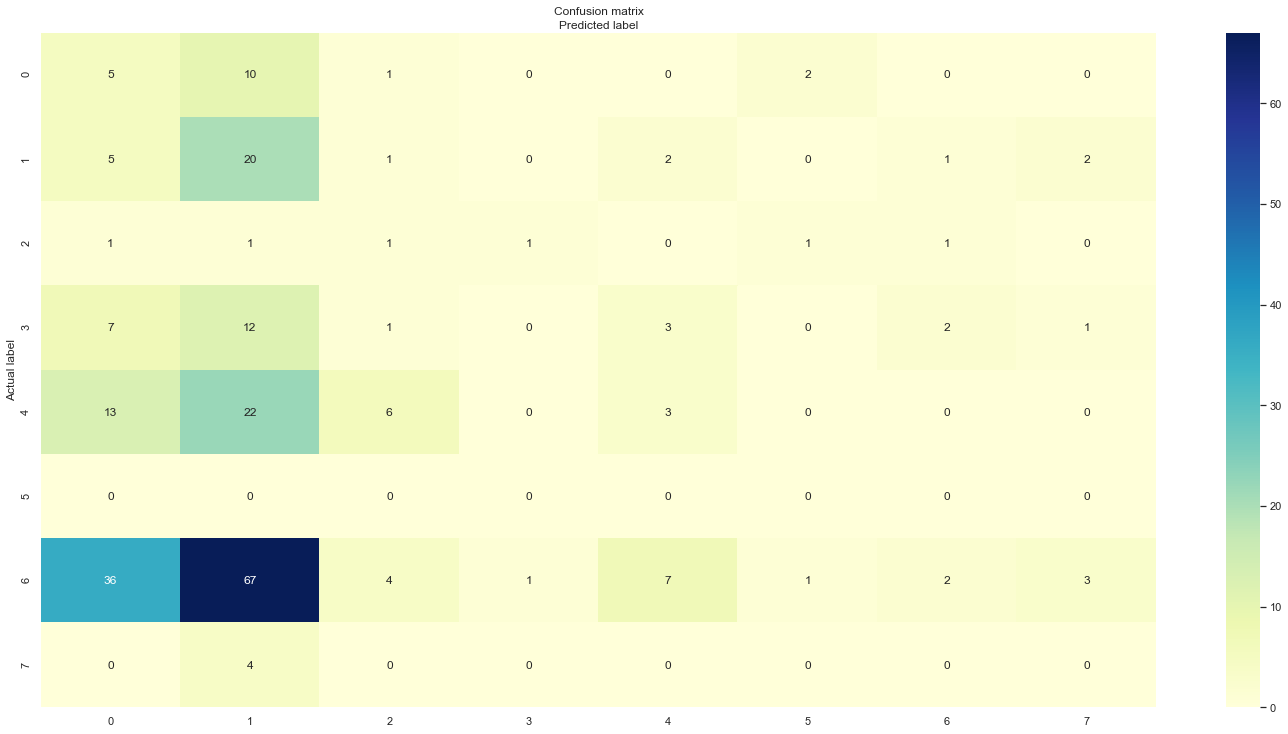

In [868]:
predicted = catboost_cls.predict(X_healthy)
cm = confusion_matrix(y_healthy, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [869]:
print(classification_report(y_healthy, predicted))

              precision    recall  f1-score   support

           0       0.07      0.28      0.12        18
           1       0.15      0.65      0.24        31
           2       0.07      0.17      0.10         6
           3       0.00      0.00      0.00        26
           4       0.20      0.07      0.10        44
           5       0.00      0.00      0.00         0
           6       0.33      0.02      0.03       121
           7       0.00      0.00      0.00         4

    accuracy                           0.12       250
   macro avg       0.10      0.15      0.07       250
weighted avg       0.22      0.12      0.07       250



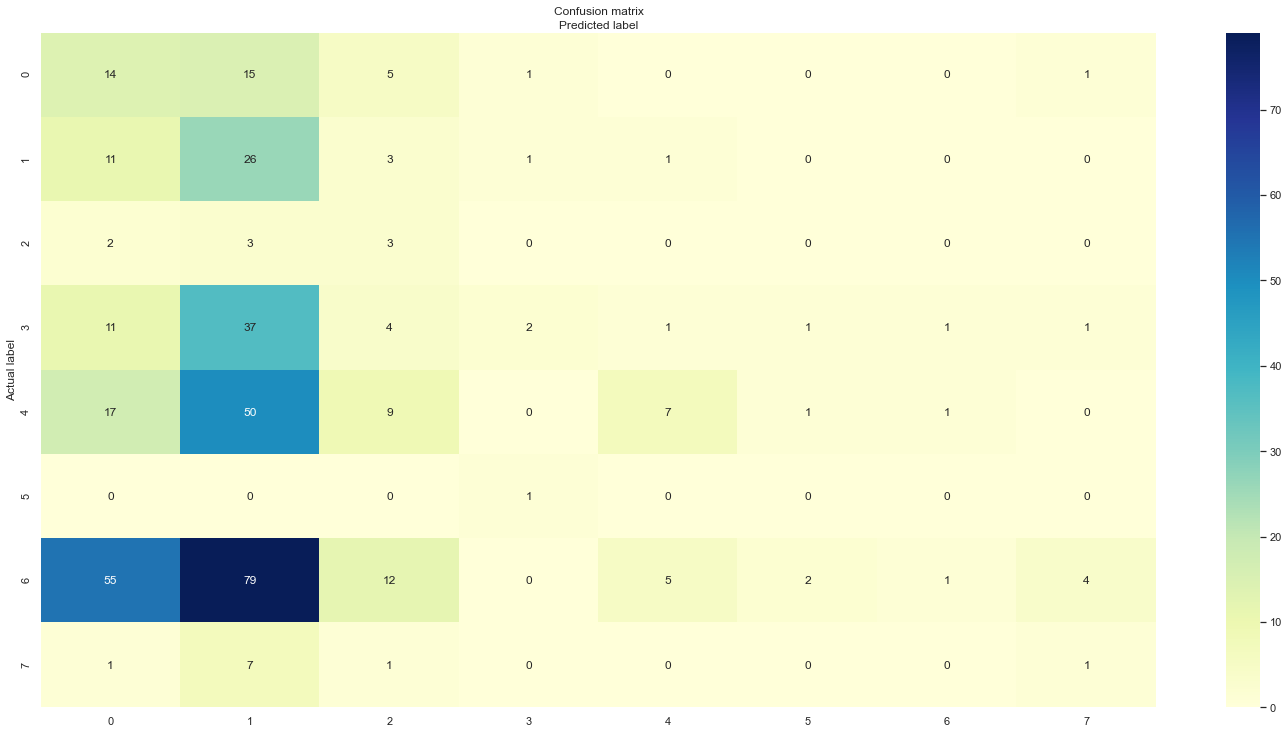

In [870]:
predicted = randf_cls.predict(X_schizo)
cm = confusion_matrix(y_schizo, predicted)

names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))

plt.xticks(tick_marks, names)
plt.yticks(tick_marks, names)

sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [871]:
print(classification_report(y_schizo, predicted))

              precision    recall  f1-score   support

           0       0.13      0.39      0.19        36
           1       0.12      0.62      0.20        42
           2       0.08      0.38      0.13         8
           3       0.40      0.03      0.06        58
           4       0.50      0.08      0.14        85
           5       0.00      0.00      0.00         1
           6       0.33      0.01      0.01       158
           7       0.14      0.10      0.12        10

    accuracy                           0.14       398
   macro avg       0.21      0.20      0.11       398
weighted avg       0.33      0.14      0.09       398

